purpose: query the EFO for parent and children terms to use for defining parallel traits in gwas catalog
based on code from obonet's tutorial:
    https://github.com/dhimmel/obonet/blob/main/examples/go-obonet.ipynb

# set-up

In [1]:
import os
import pandas as pd
import obonet as obo
import networkx
import ndex2
from scipy.stats import hypergeom
import numpy as np
import matplotlib.pyplot as plt
from upsetplot import plot as upplot
from upsetplot import from_contents
from upsetplot import UpSet
import scipy.stats as stats


In [2]:
os.chdir('/tscc/projects/ps-palmer/brittany/SUD_cross_species/')

In [3]:
save_fig=True

# functions

In [4]:
UUIDs={
    'PCNet2.0':'d73d6357-e87b-11ee-9621-005056ae23aa',
    'PCNet2.1':'e9c574f4-e87a-11ee-9621-005056ae23aa',
    'PCNet2.2':'8b4b54fa-e87d-11ee-9621-005056ae23aa'
}

In [5]:
def import_seedgenes(path,pcol='P',gene_col='GENE NAME',delim='comma', cutoff=None):
    if delim=='comma':
        df=pd.read_csv(path,sep=',')
    else:
        df=pd.read_csv(path,sep='\t')
    if pcol==None:
        print('pvalue column not specified- all genes will be used')
        cutoff=None
    if cutoff=='bonferroni':
        df=df[df[pcol]<0.05/len(df)]
    elif cutoff=='FDR_05':
        df=df[df[pcol]<0.05]
    else:
        print('cutoff not defined/custom- using all genes ')
        df=df
    print(df.head())
    return(df)

In [6]:
def import_interactome(interactome_name=None, UUIDs=UUIDs,ndex_user=None, ndex_password=None,UUID=None):
    """
    Imports a gene interactome from the NDEx database and returns it as a NetworkX graph object. Optionally,
    the function allows for importing using a unique identifier (UUID) or by an interactome name.

    The function checks if the interactome name provided corresponds to a predefined dictionary of UUIDs. If it does, it
    retrieves the network using the specified credentials. If an interactome name is not provided but a UUID is,
    it retrieves the network using the provided UUID. The nodes of pcnet_v14 are relabelled by their gene name rather than ID number.

    Parameters:
    - interactome_name (str, optional): The name of the interactome as defined in the UUIDs dictionary. If not provided
      but a UUID is, the interactome associated with the UUID is imported instead.
    - ndex_user (str, optional): The NDEx account username for accessing private networks.
    - ndex_password (str, optional): The NDEx account password for accessing private networks.
    - UUID (str, optional): A specific UUID to directly download an interactome from NDEx if the interactome name is not used.

    Returns:
    networkx.Graph: A graph object representing the interactome. Nodes and edges represent genes and their interactions, respectively.

    Notes:
    - The function uses the NDEx2 Python client and requires Internet access to NDEx's servers.
    - Depending on the access rights of the NDEx account, private or public interactomes can be retrieved.
    - The function prints the number of nodes and edges of the imported graph for diagnostic purposes.

    Raises:
    - ValueError: If neither an interactome name nor a UUID is provided.
    """    
    interactome_uuid=UUIDs[interactome_name]
    print(interactome_name)
    ndex_server='public.ndexbio.org'
    #import network based on provided interactome key
    if (interactome_name in UUIDs.keys()):
        graph = ndex2.create_nice_cx_from_server(
                    ndex_server, 
                    username=ndex_user, 
                    password=ndex_password, 
                    uuid=interactome_uuid
                ).to_networkx()
        if (interactome_name=='pcnet_v14'):
            graph=nx.relabel_nodes(graph, nx.get_node_attributes(graph, 'HGNC Symbol'))
        # print out interactome num nodes and edges for diagnostic purposes
        print('number of nodes:')
        print(len(graph.nodes))
        print('\nnumber of edges:')
        print(len(graph.edges))
        return(graph)
    elif(interactome_name==None & UUID!=None):
        print('using novel UUID. For UUIDs used in this study, see UUID_dict')
        graph = ndex2.create_nice_cx_from_server(
            ndex_server, 
            username=ndex_user, 
            password=ndex_password, 
            uuid=UUID
        ).to_networkx()
        # print out interactome num nodes and edges for diagnostic purposes
        print('number of nodes:')
        print(len(graph.nodes))
        print('\nnumber of edges:')
        print(len(graph.edges))
        return(graph)
    else:
        print('UUID/interactome name not provided- please provide either to import interactome.')

In [7]:
def format_catalog(catalog=None):
	try:
		#make all annotations lowercase for consistency for querying
		catalog['MAPPED_TRAIT']=catalog['MAPPED_TRAIT'].str.lower()
		catalog['DISEASE/TRAIT']=catalog['DISEASE/TRAIT'].str.lower()
		#filter for genes that were mapped
		mapped=catalog[~catalog['MAPPED_GENE'].isna()]
		mapped=mapped[~mapped['MAPPED_TRAIT'].isna()]
		mapped=mapped[['MAPPED_GENE','MAPPED_TRAIT','DISEASE/TRAIT','PUBMEDID']]
		mapped.columns=['GENE','MAPPED_TRAIT','DISEASE/TRAIT','PUBMEDID']
		#filter for genes that were reported
		rep=catalog[~catalog['REPORTED GENE(S)'].isna()]
		rep=rep[~rep['MAPPED_TRAIT'].isna()]
		rep=rep[~rep['REPORTED GENE(S)'].str.contains('Intergenic')]
		rep=rep[['REPORTED GENE(S)','MAPPED_TRAIT','DISEASE/TRAIT','PUBMEDID']]
		rep.columns=['GENE','MAPPED_TRAIT','DISEASE/TRAIT','PUBMEDID']
		cat=pd.concat([rep, mapped])
		cat['GENE']=cat['GENE'].str.split('; ')
		cat=cat.explode('GENE')
		cat=cat[~(cat['GENE'].str.contains('mapped'))]
		cat['GENE']=cat['GENE'].str.split(', ')
		cat=cat.explode('GENE')
		cat['GENE']=cat['GENE'].str.split(' - ')
		cat=cat.explode('GENE')
		cat['GENE']=cat['GENE'].astype('str')
		cat=cat[~(cat['GENE'].str.contains('intergenic'))]
		cat['TRAIT']=cat['MAPPED_TRAIT'] + ": " +cat['DISEASE/TRAIT']+ " (PMID: "+(cat['PUBMEDID'].astype(str))+")"
		cat=cat.dropna()
		return(cat)
	except:
		print('please add gwas catalog file.')

## FUNCTION TO GET DESCENDENTS FROM EFO NETWORK

In [8]:
#return list set of traits in EFO ontology including parent- reported by name
def return_efo_descendents_name(graph,id_to_name, term):
    l=list(sorted(id_to_name[subterm] for subterm in networkx.ancestors(graph, term))) #descendents get subterms- not sure why but I tested it and OBONET says so as well
    l.append(id_to_name[term])
    return list(set(l))

In [9]:
#return list set of traits in EFO ontology including parent- reported by name
def return_efo_ancestors_name(graph,id_to_name, term):
    print('getting ancestors for '+term+' : '+id_to_name[term])
    l=list((id_to_name[supterm] for supterm in networkx.descendants(graph, term))) #descendents get superterms- not sure why
    #l.append(id_to_name[term])
    return list(set(l))

# import network genelists

## Interactome Set-up

pcnet2- versions 
from wright et al. 2024 preprint:
PCNet 2.0= best-performing ranked composite (top 15 interactomes, 3.85M interactions)
PCNet 2.1= top 8 interactomes, 1.75M interactions
PCNet 2.2= top 10 co-citation-free interactomes, 3.32M interactions 

In [10]:
interactome_name='PCNet2.0'

In [11]:
graph=import_interactome(interactome_name)

PCNet2.0
number of nodes:
19267

number of edges:
3852119


In [12]:
all_nodes=list(graph.nodes())

## import NPS scores and seed genes

In [13]:
mag_dir='magma/seed_genes/'
file_dict={
    'loco':mag_dir+'loco_win10_annot.tsv',
    'ext_munged':mag_dir+'ext_munged_annot.tsv',
    'ext':mag_dir+'ext_orig_annot.tsv',
    'ext_st22':mag_dir+'all_tests_ext1_st22_genes.csv',   
}

In [14]:
seed_dict={}

In [15]:
loco=pd.read_csv(file_dict['loco'],sep='\t')
loco_bonf_cut=2.6389402016150313e-06 #calculated in define_seed_genes_orthologs- from raw magma results before adding in ortholog info
seed_dict['loco_FDR']=(set(loco[loco['Q']<0.05]['HM_ORTHO']))
seed_dict['loco_bonf']=(set(loco[loco['P']<loco_bonf_cut]['HM_ORTHO']))

In [16]:
ext=pd.read_csv(file_dict['ext'],sep='\t')
ext_bonf_cut=0.05/len(ext) # no ortholog adding, so can calculate from this table
seed_dict['ext_FDR']=(set(ext[ext['Q']<0.05]['GENE']))
seed_dict['ext_bonf']=(set(ext[ext['P']<ext_bonf_cut]['GENE']))

In [17]:
'''ext=pd.read_csv(file_dict['ext'],sep='\t')
ext_bonf_cut=0.05/len(ext) # no ortholog adding, so can calculate from this table
seed_dict['ext_munged_FDR']=(set(ext[ext['Q']<0.05]['GENE']))
seed_dict['ext_munged_bonf']=(set(ext[ext['P']<ext_bonf_cut]['GENE']))'''

"ext=pd.read_csv(file_dict['ext'],sep='\t')\next_bonf_cut=0.05/len(ext) # no ortholog adding, so can calculate from this table\nseed_dict['ext_munged_FDR']=(set(ext[ext['Q']<0.05]['GENE']))\nseed_dict['ext_munged_bonf']=(set(ext[ext['P']<ext_bonf_cut]['GENE']))"

In [18]:
ext_st22=pd.read_csv(file_dict['ext_st22'])
seed_dict['ext_st22']=set(ext_st22['GENE NAME'])
seed_dict['ext_st22']=set(ext_st22['GENE NAME'])

In [19]:
seed_dict['ext_top500']=set(ext[(ext['GENE'].isin(all_nodes))].nsmallest(500,'P')['GENE'])

In [20]:
seed_dict.keys()

dict_keys(['loco_FDR', 'loco_bonf', 'ext_FDR', 'ext_bonf', 'ext_st22', 'ext_top500'])

In [21]:
NPS_dict={}
for k in seed_dict.keys():
    for u in UUIDs.keys():
        p=('network_scores/'+k+'_'+u+'_zscore.tsv')
        if os.path.isfile(p):
            t=pd.read_csv('network_scores/'+k+'_'+u+'_zscore.tsv',header=None, sep='\t')
            t.index=t[0]
            t=t.drop(columns=[0])
            t=t[1].squeeze()
            t = pd.DataFrame({'z':t})
            NPS_dict[k+'_'+u]=t

In [22]:
NPS_dict_series={}
for k in seed_dict.keys():
    for u in UUIDs.keys():
        p=('network_scores/'+k+'_'+u+'_zscore.tsv')
        if os.path.isfile(p):
            t=pd.read_csv('network_scores/'+k+'_'+u+'_zscore.tsv',header=None, sep='\t')
            t.index=t[0]
            t=t.drop(columns=[0])
            #t=t[1].squeeze()
            #t = pd.DataFrame({'z':t})
            NPS_dict_series[k+'_'+u]=t

In [23]:
NPS_dict.keys()

dict_keys(['loco_FDR_PCNet2.0', 'loco_FDR_PCNet2.2', 'loco_bonf_PCNet2.0', 'loco_bonf_PCNet2.2', 'ext_FDR_PCNet2.0', 'ext_FDR_PCNet2.2', 'ext_bonf_PCNet2.0', 'ext_bonf_PCNet2.2', 'ext_st22_PCNet2.0', 'ext_top500_PCNet2.0'])

## choose datasets for analysis- put gene lists into dictionary

In [24]:
cut_single=1.5
cut_comb=3

In [25]:
cut_r= 'FDR'
#cut_h='bonf'
cut_h=None
trait_r='loco'
trait_h='ext_top500'

#labels
if cut_h==None:
    label_h=trait_h
else:
    label_h=trait_h+'_'+cut_h
if cut_r==None:
    label_r=trait_r
else:
    label_r=trait_r+'_'+cut_r
#seed genes
seed_r=seed_dict[label_r]
seed_h=seed_dict[label_h]
#NPS scores
NPS_r=NPS_dict[label_r+'_'+interactome_name]
NPS_h=NPS_dict[label_h+'_'+interactome_name]

In [26]:
NPS_r.merge(NPS_h)
NPS = NPS_h.join(NPS_r, lsuffix="h", rsuffix="r")
NPS = NPS.assign(zhr=NPS.zh * NPS.zr)

In [27]:
coloc_dict={
    'seed_r':seed_r,
    'seed_h':seed_h,
    'seed_hm':list(set(seed_r).intersection(seed_h)),
    'net':list(NPS[(NPS.zh>cut_single)&(NPS.zr>cut_single)&(NPS.zhr>cut_comb)].index),
    'graph':all_nodes
}

# import EFO table from GWAS catalog

In [28]:
#ontology mapping table for GWAS catalog
onto=pd.read_csv('validation_datasets/trait_mappings.txt',sep='\t')

In [29]:
onto['EFO_term']=onto['EFO URI'].apply(lambda x: x.split('/')[len(x.split('/'))-1])
onto['EFO_term']=onto['EFO_term'].str.replace('_',':')

In [30]:
onto['EFO_parent']=onto['Parent URI'].apply(lambda x: x.split('/')[len(x.split('/'))-1])
onto['EFO_parent']=onto['EFO_parent'].str.replace('_',':')

In [31]:
onto['Disease trait']=onto['Disease trait'].str.lower()
o=set(onto['Disease trait'])
e=(set(onto['EFO_term']))

# import the network of EFO terms

In [32]:
#graphical representation of the EFO ontology database
graph = obo.read_obo('https://www.ebi.ac.uk/efo/efo.obo')

In [33]:
#get id from name or name from ID - from the EFO website
id_to_name = {id_: data.get('name') for id_, data in graph.nodes(data=True)}
name_to_id = {data['name']: id_ for id_, data in graph.nodes(data=True) if 'name' in data}

In [34]:
nodes=list(graph.nodes())

In [35]:
# check for non-specific network names
[x for x in nodes if ('_' in x)]
#some nodes contain "_" and some contain ":"- WHY- only the 2 BAO entries, an inexplicable URL, and NCBITaxon_Union- just replace BAO
#BAO_x are Cycline-6-phospah
# ['BAO_0000875']:'Cyclic adenosine monophosphate'
# ['BAO_0000925']:'Glucose-6-phosphate'
# NCBITaxon_Union_0000023 has no definition online.

#not going to replace substring- but here's the code for that

#nodesf=set([(lambda x: x.replace('_',':'))(x) for x in nodes])
#len(set(nodes))-len(nodesf)
#length is equal so not redundant

['BAO_0000875',
 'BAO_0000925',
 'http://dbpedia.org/resource/Republic_of_Ireland',
 'NCBITaxon_Union:0000023']

In [36]:
[x for x in nodes if ('BAO' in x)]

['BAO_0000875', 'BAO_0000925']

In [37]:
[id_to_name[x] for x in nodes if ('NCIT' in x)]

['S-Adenosylhomocysteine',
 'decreased attention',
 'Tilarginine',
 'Country',
 'Guanosine Diphosphate',
 'nervousness',
 'Gentisic Acid',
 'Alpha-Ketoglutaric Acid',
 'Hippuric Acid',
 'sleepiness']

In [38]:
print(len(e))
print(len(nodes))
print(len(e.intersection(nodes)))
#almost all GWAS catalog terms in obo graph

15583
49138
15572


In [39]:
networkx.is_directed_acyclic_graph(graph) #undirected network??? HOW???

False

In [40]:
networkx.get_node_attributes(graph,'CHEBI:133727')

{}

# list traits of interest (parents) for externalizing related traits

In [41]:
#list of parent nodes - can only use ones that exist in the EFO
ppsych=['HP:0011446', 'EFO:0006848','EFO:0000677', 'MONDO:0002025'] 
#'Abnormality of mental function','mental or behavioural disorder biomarker', 'mental or behavioural disorder', psychiatric disorder 
pdrug='MONDO:0002494' #'substance-related disorder'
p=ppsych+[pdrug]
# mental or behavioural disorder ('EFO:0000677') child of  brain disease (EFO:0005774) and psychiatric disorder (MONDO:0002025)
   #remove brain disease

In [42]:
#'NCIT_C180615': Externalizing Disorder Symptoms
# NCIT:C121300: Externalizing Problems Composite Score
print('NCIT:C180615' in nodes)
print('NCIT:C121300' in nodes)

False
False


In [43]:
name_to_id['substance-related disorder']

'MONDO:0002494'

In [44]:
id_to_name['EFO:0006848']

'mental or behavioural disorder biomarker'

## query for 'MONDO:0002494': 'substance-related disorder'

In [45]:
return_efo_ancestors_name(graph,id_to_name,pdrug)

getting ancestors for MONDO:0002494 : substance-related disorder


['psychiatric disorder',
 'material property',
 'disposition',
 'organism',
 'Homo sapiens',
 'Eukaryota',
 'disease',
 'material entity',
 'experimental factor']

In [46]:
psych_term=[]
for i in ppsych:
    psych_term=psych_term+return_efo_descendents_name(graph,id_to_name,i)
psych_ID=[name_to_id[term] for term in psych_term if term in name_to_id]


In [47]:
SUD_traits=e.intersection(list(networkx.ancestors(graph, pdrug))+[pdrug])

# query gwas catalog for traits of interest

## import gwas catalog associations

In [48]:
gwas_catalog=pd.read_csv('validation_datasets/gwas-catalog_v1.0.2_20240807.tsv',sep='\t',low_memory=False)
cat=format_catalog(gwas_catalog)
cat=cat.merge(onto, left_on='DISEASE/TRAIT',right_on='Disease trait')

In [49]:
set(onto['EFO_parent'])

{'EFO:0000001',
 'EFO:0000319',
 'EFO:0000405',
 'EFO:0000408',
 'EFO:0000540',
 'EFO:0000589',
 'EFO:0000616',
 'EFO:0000618',
 'EFO:0001444',
 'EFO:0004298',
 'EFO:0004324',
 'EFO:0004503',
 'EFO:0004529',
 'EFO:0004582',
 'EFO:0004732',
 'EFO:0004872',
 'GO:0008150',
 'NR'}

## check for overlap of parent traits of GWAS catalog

In [50]:
coloc_dict.keys()

dict_keys(['seed_r', 'seed_h', 'seed_hm', 'net', 'graph'])

In [51]:
coloc_dict_cat={}
for k in coloc_dict.keys():
    coloc_dict_cat[k]=set(coloc_dict[k]).intersection(list(cat['GENE'].dropna()))

In [52]:
cat['Parent URI']

0          http://www.ebi.ac.uk/efo/EFO_0001444
1          http://www.ebi.ac.uk/efo/EFO_0001444
2          http://www.ebi.ac.uk/efo/EFO_0001444
3          http://www.ebi.ac.uk/efo/EFO_0001444
4          http://www.ebi.ac.uk/efo/EFO_0001444
                           ...                 
3321585    http://www.ebi.ac.uk/efo/EFO_0000001
3321586    http://www.ebi.ac.uk/efo/EFO_0000001
3321587    http://www.ebi.ac.uk/efo/EFO_0000001
3321588    http://www.ebi.ac.uk/efo/EFO_0000001
3321589    http://www.ebi.ac.uk/efo/EFO_0000001
Name: Parent URI, Length: 3321590, dtype: object

In [53]:
#catalog of genes present in the gwas catalog with annotations for the given traits
parent_dict={}
parent_dict_genes={}
parent_dict_or={}
for k in sorted(set(cat['Parent term'])):
    t=set(cat[cat['Parent term']==k]['GENE'].dropna())
    M= len(coloc_dict_cat['graph']) #population is the number of genes in PCNet that are annotated in the GWAS catalog
    n= len(coloc_dict_cat['graph'].intersection(t)) #number of genes in the PCNet that are annotated for the trait of interest
    N= len(coloc_dict_cat['net']) #number of genes in network that are annotated in the GWAS catalog
    x= len(coloc_dict_cat['net'].intersection(t)) #number of genes in network that are anntated for the trait of interest
    
    contingency_table = [
    [x, N - x],
    [n - x, M - N - (n - x)]]

    odds_ratio, p_intersect = stats.fisher_exact(contingency_table, alternative='greater')
    
    parent_dict[k]=-np.log10(p_intersect)  
    parent_dict_or[k]=odds_ratio
    parent_dict_genes[k]=coloc_dict_cat['net'].intersection(t)

    print("enrichment of network nodes in genes in the GWAS catalog annotated for "+k+' p='+str(p_intersect))
    print("odds ratio is OD="+str(odds_ratio))
    print('number of annotated genes in PCNet: '+ str(len(t.intersection(coloc_dict_cat['graph']))))
    print('number of annotated genes in network: '+ str(len(t.intersection(coloc_dict_cat['net'])))+'\n')


enrichment of network nodes in genes in the GWAS catalog annotated for Biological process p=1.4787394460435818e-18
odds ratio is OD=2.8720297713981924
number of annotated genes in PCNet: 7627
number of annotated genes in network: 202

enrichment of network nodes in genes in the GWAS catalog annotated for Body measurement p=3.082148680635438e-11
odds ratio is OD=2.3139730502245817
number of annotated genes in PCNet: 10018
number of annotated genes in network: 222

enrichment of network nodes in genes in the GWAS catalog annotated for Cancer p=8.60161968222632e-11
odds ratio is OD=2.163645357025536
number of annotated genes in PCNet: 5135
number of annotated genes in network: 138

enrichment of network nodes in genes in the GWAS catalog annotated for Cardiovascular disease p=2.087765331978971e-08
odds ratio is OD=2.053050086558493
number of annotated genes in PCNet: 3560
number of annotated genes in network: 100

enrichment of network nodes in genes in the GWAS catalog annotated for Card

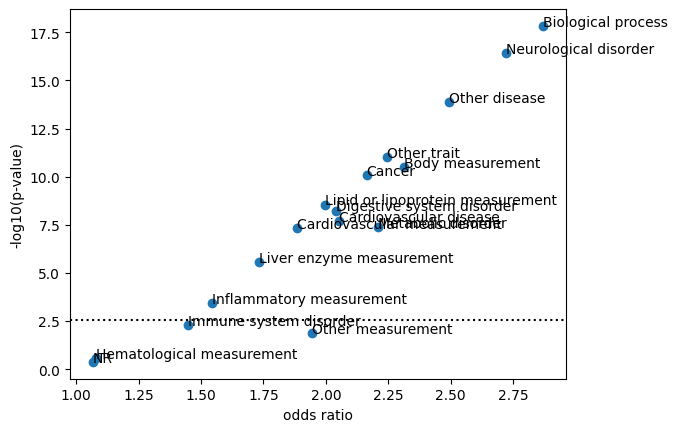

In [54]:
plt.scatter(x=parent_dict_or.values(),y=parent_dict.values())
plt.xlabel('odds ratio')
plt.ylabel('-log10(p-value)')
plt.axhline(-np.log10(0.05/len(set(cat['Parent term']))),color='black',ls=':')

for i in parent_dict_or.keys():
    plt.annotate(i, (parent_dict_or[i], parent_dict[i]))

Text(0.5, 0, 'GWAS Catalog Parent Term')

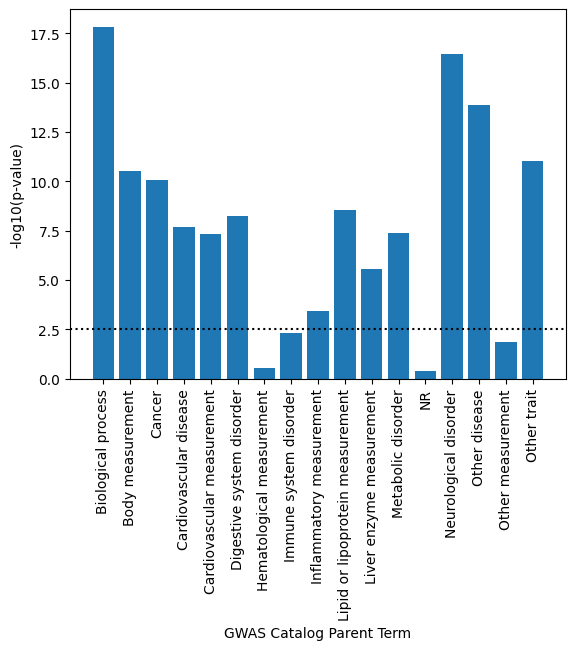

In [55]:
plt.bar(x=parent_dict.keys(),height=parent_dict.values())
plt.xticks(rotation=90)
plt.ylabel('-log10(p-value)')
plt.axhline(-np.log10(0.05/len(set(cat['Parent term']))),color='black',ls=':')
plt.xlabel('GWAS Catalog Parent Term')

# identify overlapping network genes between EFO parent terms in GWAS catalog

## make volcano plots for parent terms

In [62]:
onto['EFO_parent_idotoname']=onto['EFO_parent'].map(id_to_name)

In [63]:
onto[['Parent term','EFO_parent_idtoname','EFO_parent']].drop_duplicates()

,Parent term,EFO_parent_idtoname,EFO_parent
0,Cancer,neoplasm,EFO:0000616
4,Other trait,experimental factor,EFO:0000001
8,Immune system disorder,immune system disease,EFO:0000540
11,Other disease,disease,EFO:0000408
46,Cardiovascular disease,cardiovascular disease,EFO:0000319
49,Neurological disorder,nervous system disease,EFO:0000618
71,Other measurement,measurement,EFO:0001444
364,Biological process,biological_process,GO:0008150
537,Lipid or lipoprotein measurement,lipoprotein measurement,EFO:0004732
790,Body measurement,body weights and measures,EFO:0004324


In [182]:
parents=set(cat['EFO_parent'])
parents.discard('NR')
for k in sorted(parents):
    print(id_to_name[k])
    if k in nodes:
        #return_efo_ancestors_name(graph,id_to_name,k)
        #print(': \n')
        print((list((id_to_name[supterm] for supterm in networkx.descendants(graph, k))))) #descendents get superterms- not sure why)
        print('\n')
    else:
        print(' not in EFO. \n')

experimental factor
[]


cardiovascular disease
['Homo sapiens', 'material entity', 'material property', 'organism', 'cardiovascular system', 'multicellular organism', 'anatomy basic component', None, 'circulatory system', None, 'Eukaryota', None, 'anatomical entity', None, None, 'disposition', 'disease', 'anatomical structure', 'organism part', 'anatomical system', 'experimental factor']


digestive system disease
['digestive system', 'organism', 'multicellular organism', 'disposition', 'Eukaryota', 'disease', 'anatomical structure', 'organism part', 'anatomical system', 'anatomy basic component', 'alimentary part of gastrointestinal system', 'experimental factor', None, 'anatomical entity', 'Homo sapiens', 'material entity', 'material property']


disease
['experimental factor', 'disposition', 'material property']


immune system disease
['immune system', 'organism', 'disposition', 'Eukaryota', 'disease', 'organism part', 'experimental factor', 'anatomical entity', 'Homo sapiens', 'm

In [181]:
parents=set(cat['EFO_parent'])
parents.discard('NR')
parent_term_depth={}
for k in sorted(parents):
    if k in nodes:
        #return_efo_ancestors_name(graph,id_to_name,k)
        #print(': \n')
        if 'Homo sapiens' in (list((id_to_name[supterm] for supterm in networkx.descendants(graph, k)))):
            x=len(list((id_to_name[supterm] for supterm in networkx.descendants(graph, k))))-1
        else:
            x=len(list((id_to_name[supterm] for supterm in networkx.descendants(graph, k))))
        parent_term_depth[id_to_name[k]]=x
    else:
        print(' not in EFO. \n')

In [184]:
parent_term_depth

{'experimental factor': 0,
 'cardiovascular disease': 20,
 'digestive system disease': 16,
 'disease': 3,
 'immune system disease': 10,
 'metabolic disease': 7,
 'neoplasm': 15,
 'nervous system disease': 16,
 'measurement': 2,
 'cardiovascular measurement': 3,
 'body weights and measures': 4,
 'hematological measurement': 3,
 'lipid measurement': 4,
 'liver enzyme measurement': 3,
 'lipoprotein measurement': 5,
 'inflammatory biomarker measurement': 3,
 'biological_process': 2}

### write looping enrichment function

In [158]:
def hypergeom_gwascat (t,coloc_dict_cat):
    M= len(coloc_dict_cat['graph']) #population is the number of genes in PCNet that are annotated in the GWAS catalog
    n= len(coloc_dict_cat['graph'].intersection(t)) #number of genes in the PCNet that are annotated for the trait of interest
    N= len(coloc_dict_cat['net']) #number of genes in network that are annotated in the GWAS catalog
    x= len(coloc_dict_cat['net'].intersection(t)) #number of genes in network that are anntated for the trait of interest
    
    contingency_table = [
    [x, N - x],
    [n - x, M - N - (n - x)]]

    odds_ratio, p_intersect = stats.fisher_exact(contingency_table, alternative='greater')
    gene_list=coloc_dict_cat['net'].intersection(t)
    return odds_ratio, p_intersect, gene_list

In [188]:
#catalog of genes present in the gwas catalog with annotations for the given traits
enr_tbl=pd.DataFrame(columns=['trait','parent_trait','network_genes','odds_ratio','p_intersect'])

for p in sorted(set(onto['EFO_parent_idtoname'].dropna())):
    #select parent term
    print('analyzing '+p)
    #get all children terms (not all descendents, just first level children)- loop over
    for c in list(map(lambda x: id_to_name[x],list(graph.predecessors(name_to_id[p])))):
        grand_children=return_efo_descendents_name(graph,id_to_name, name_to_id[c])
        # get all grand children- use all terms as subterm
        t=set(cat[cat['EFO term'].isin(grand_children)]['GENE'].dropna())
        odds_ratio, p_intersect, gene_list= hypergeom_gwascat(t,coloc_dict_cat)
        if (len(gene_list)>0):
            enr_tbl = pd.concat([pd.DataFrame([[c, p, gene_list, odds_ratio, p_intersect]], columns=enr_tbl.columns), enr_tbl], ignore_index=True)
    

analyzing biological_process
analyzing body weights and measures
analyzing cardiovascular disease
analyzing cardiovascular measurement
analyzing digestive system disease
analyzing disease
analyzing experimental factor
analyzing hematological measurement
analyzing immune system disease
analyzing inflammatory biomarker measurement
analyzing lipid measurement
analyzing lipoprotein measurement
analyzing liver enzyme measurement
analyzing measurement
analyzing metabolic disease
analyzing neoplasm
analyzing nervous system disease


In [198]:
for p in sorted(set(onto['EFO_parent_idtoname'].dropna())):
    t=enr_tbl[enr_tbl['parent_trait']==p]
    fig=plt.scatter(x=t.odds_ratio,y=t.p_intersect)
    fig=plt.xlabel('odds ratio')
    fig=plt.ylabel('-log10(p-value)')
    fig=plt.axhline(-np.log10(0.05/len(p)),color='black',ls=':')
    fig
    plt.clf()
    #for i in t.trait:
    #    plt.annotate(i, (parent_dict_or[i], parent_dict[i]))

<Figure size 640x480 with 0 Axes>

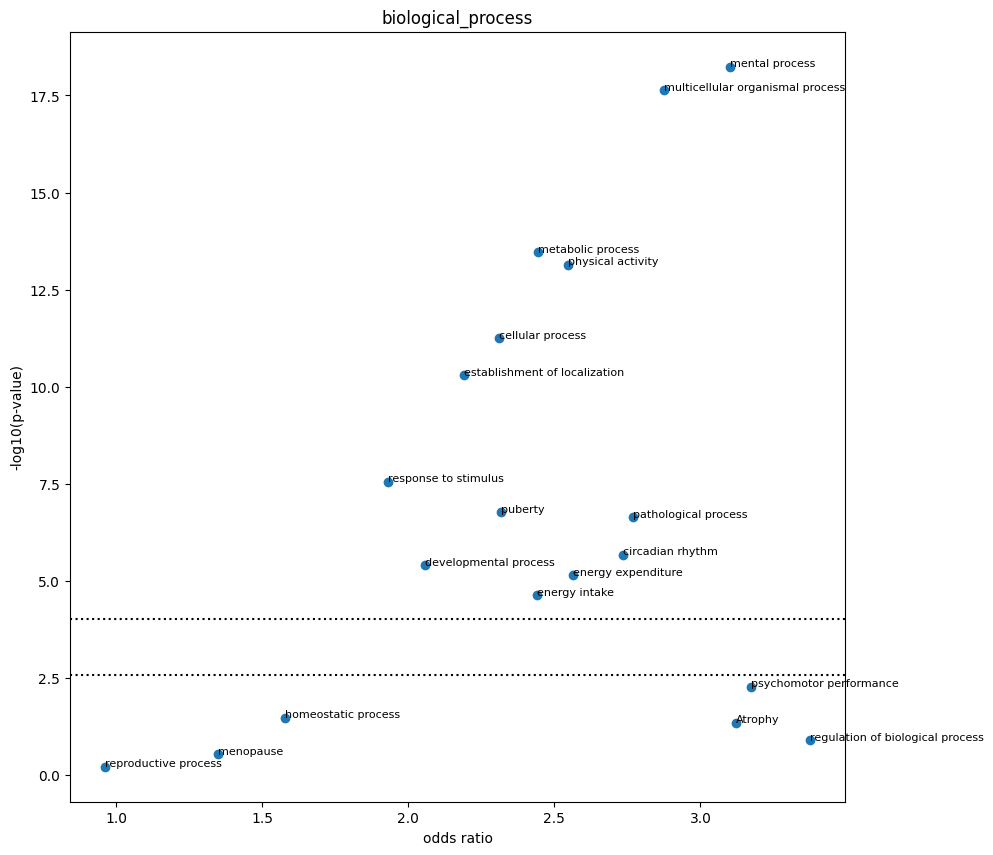

<Figure size 640x480 with 0 Axes>

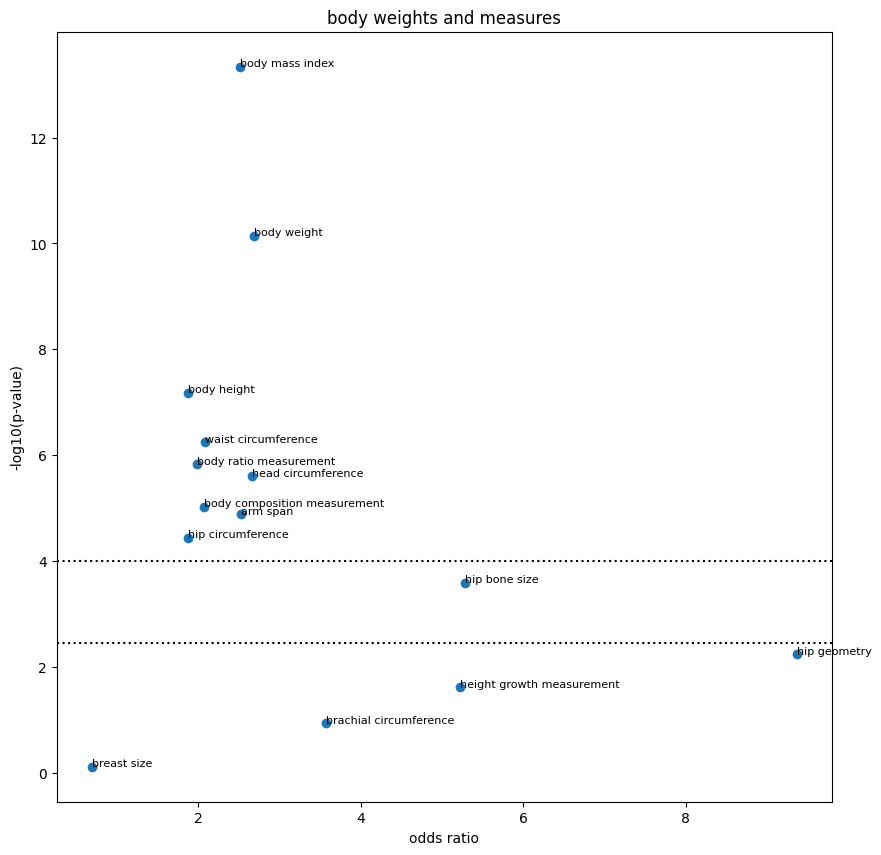

<Figure size 640x480 with 0 Axes>

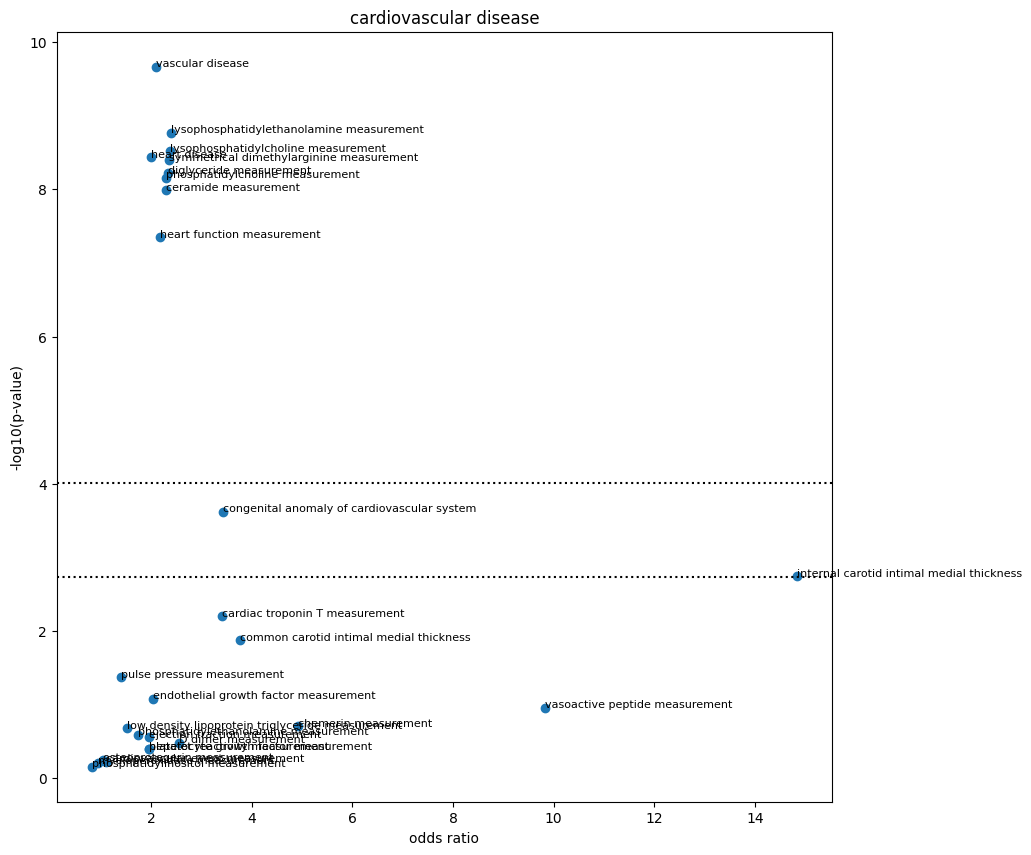

<Figure size 640x480 with 0 Axes>

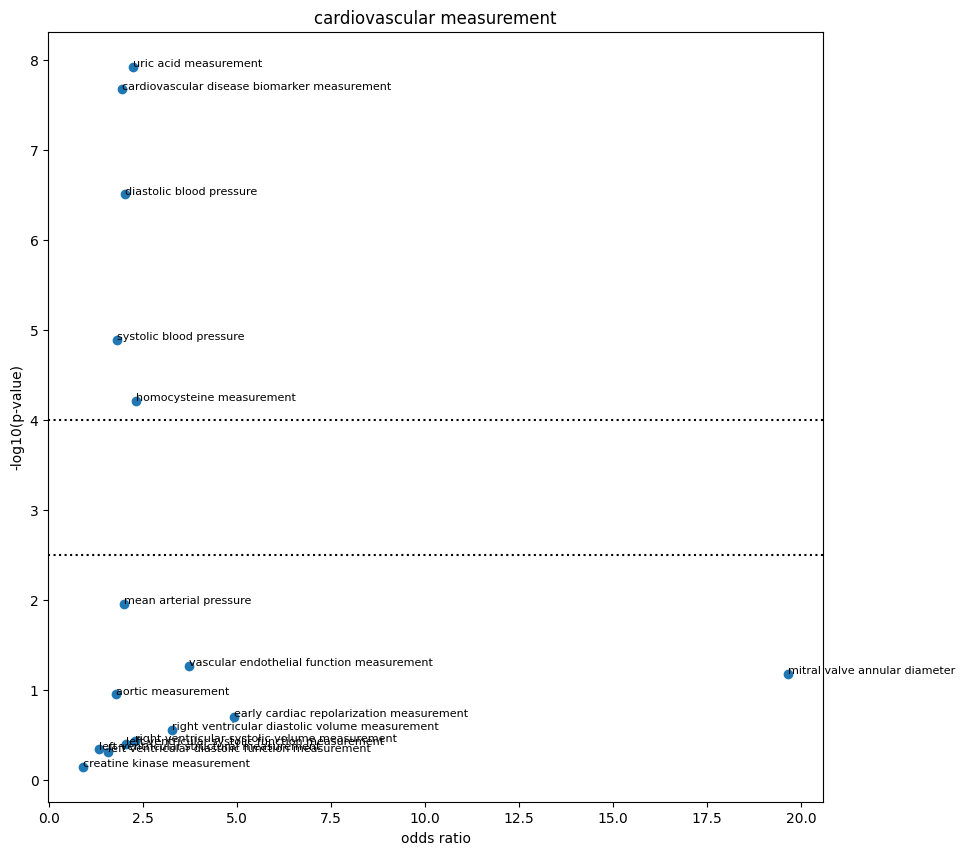

<Figure size 640x480 with 0 Axes>

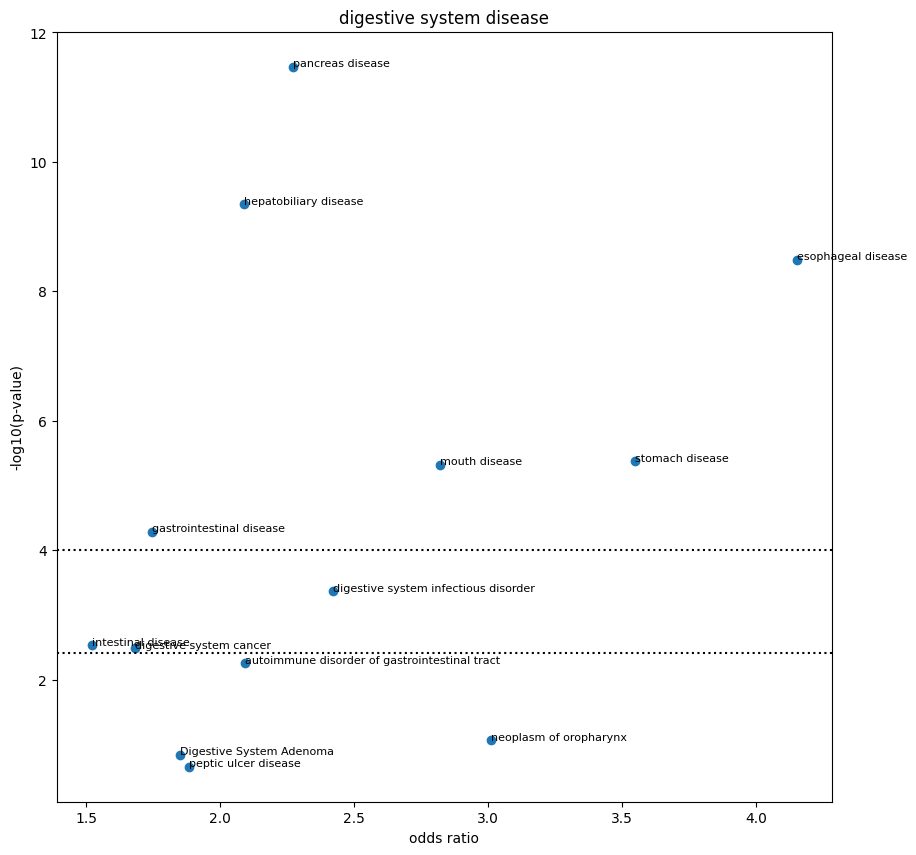

<Figure size 640x480 with 0 Axes>

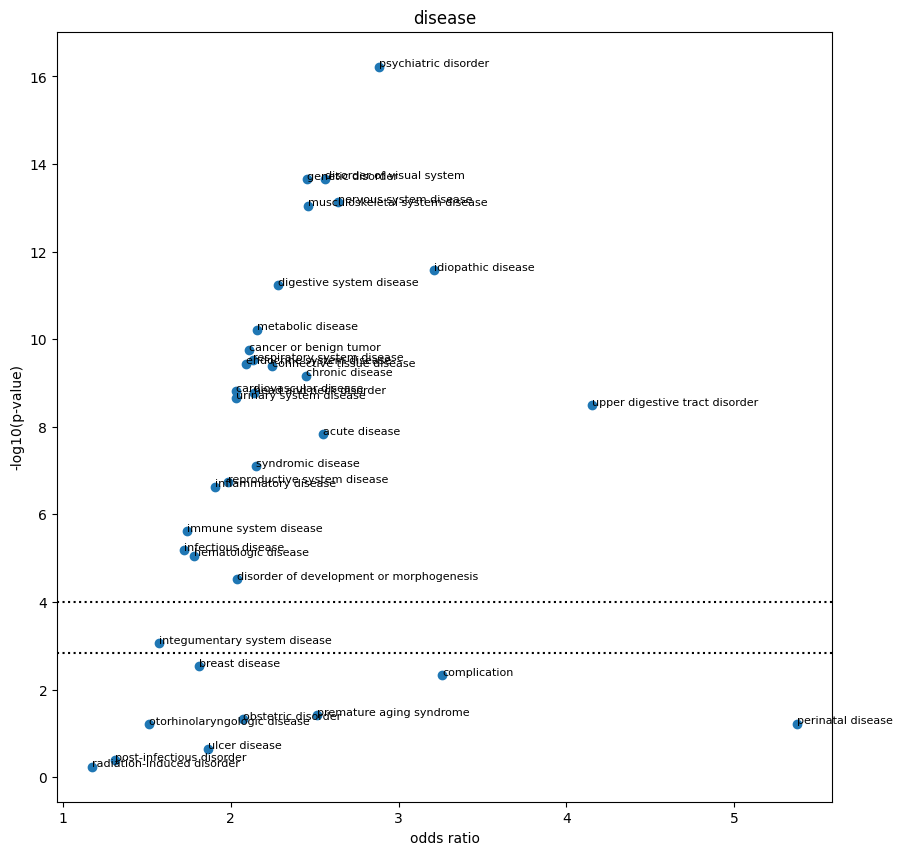

<Figure size 640x480 with 0 Axes>

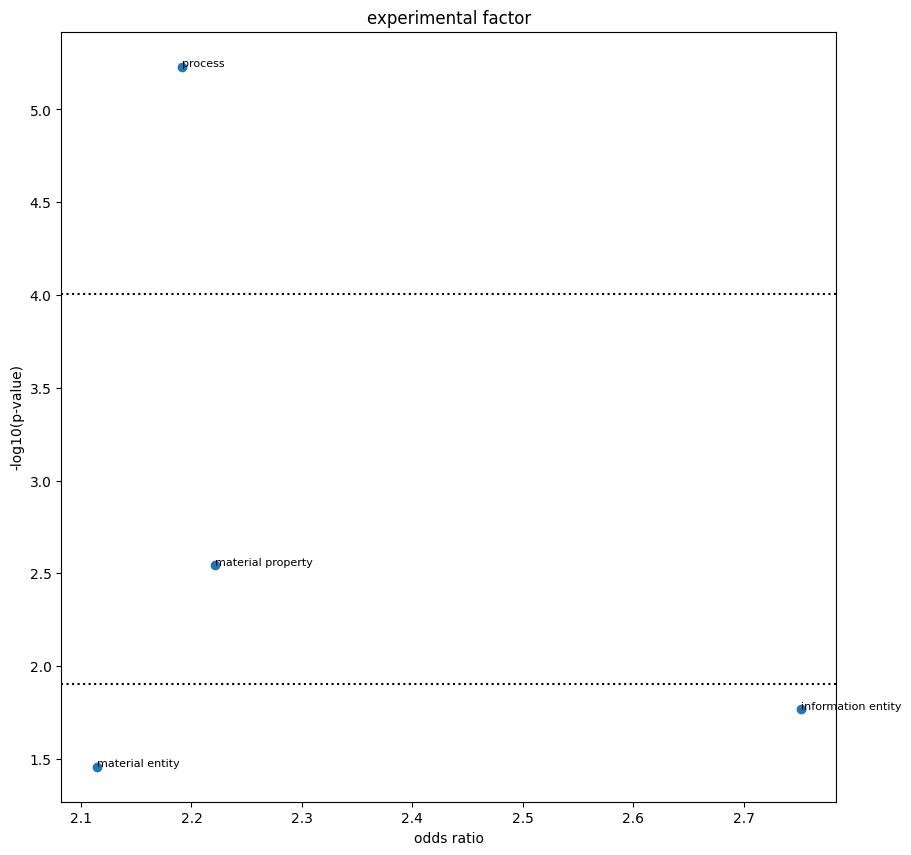

<Figure size 640x480 with 0 Axes>

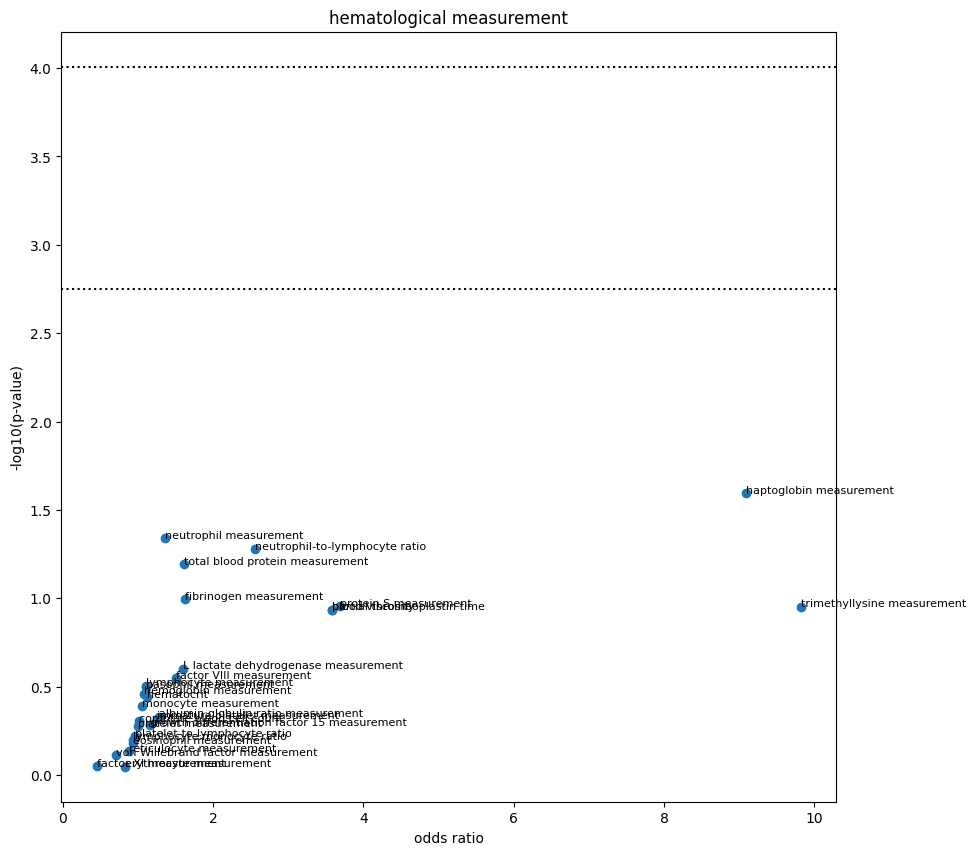

<Figure size 640x480 with 0 Axes>

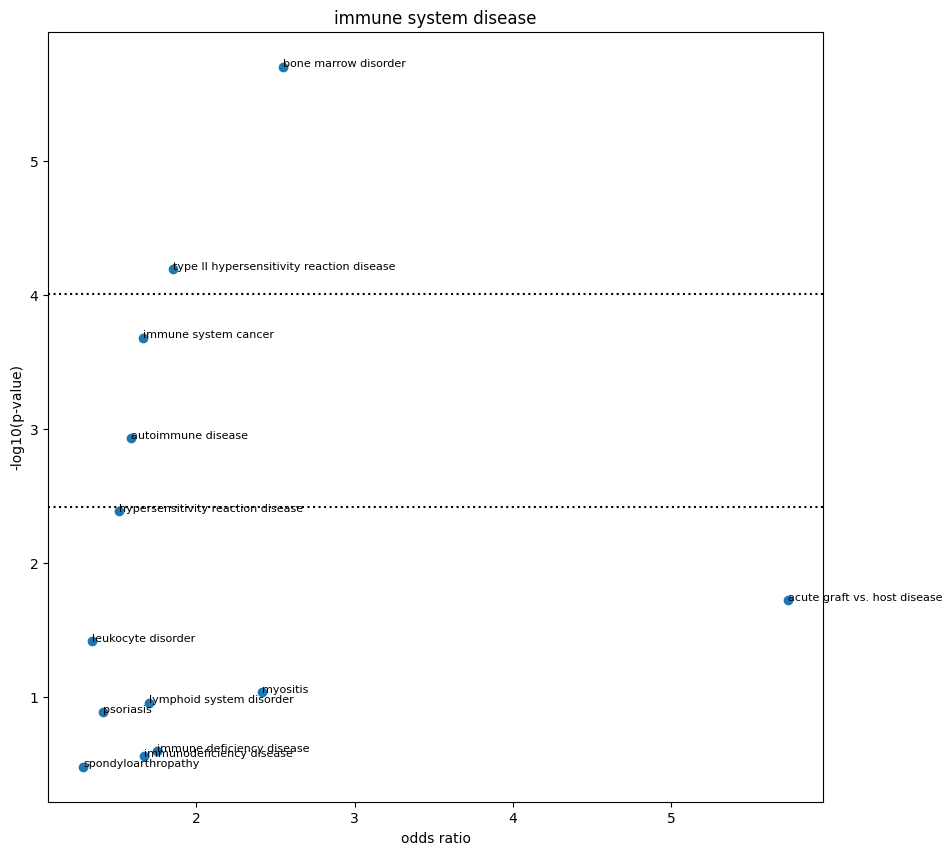

<Figure size 640x480 with 0 Axes>

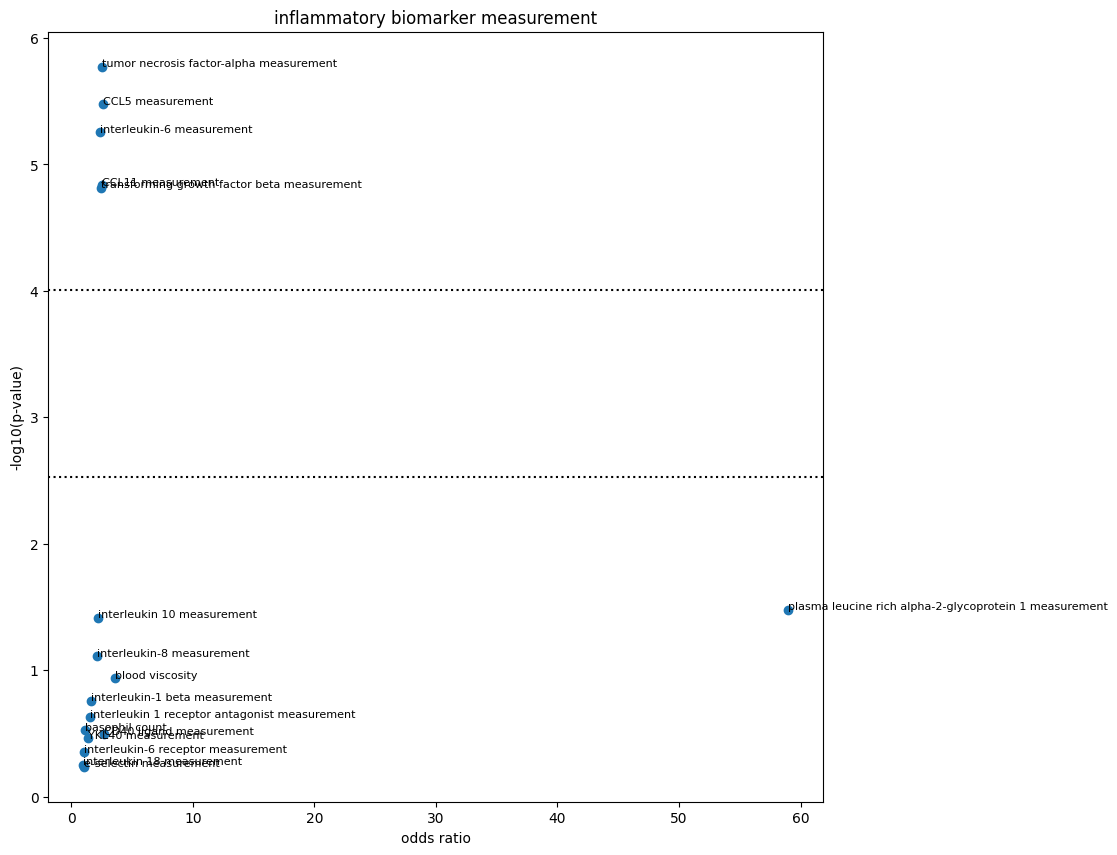

<Figure size 640x480 with 0 Axes>

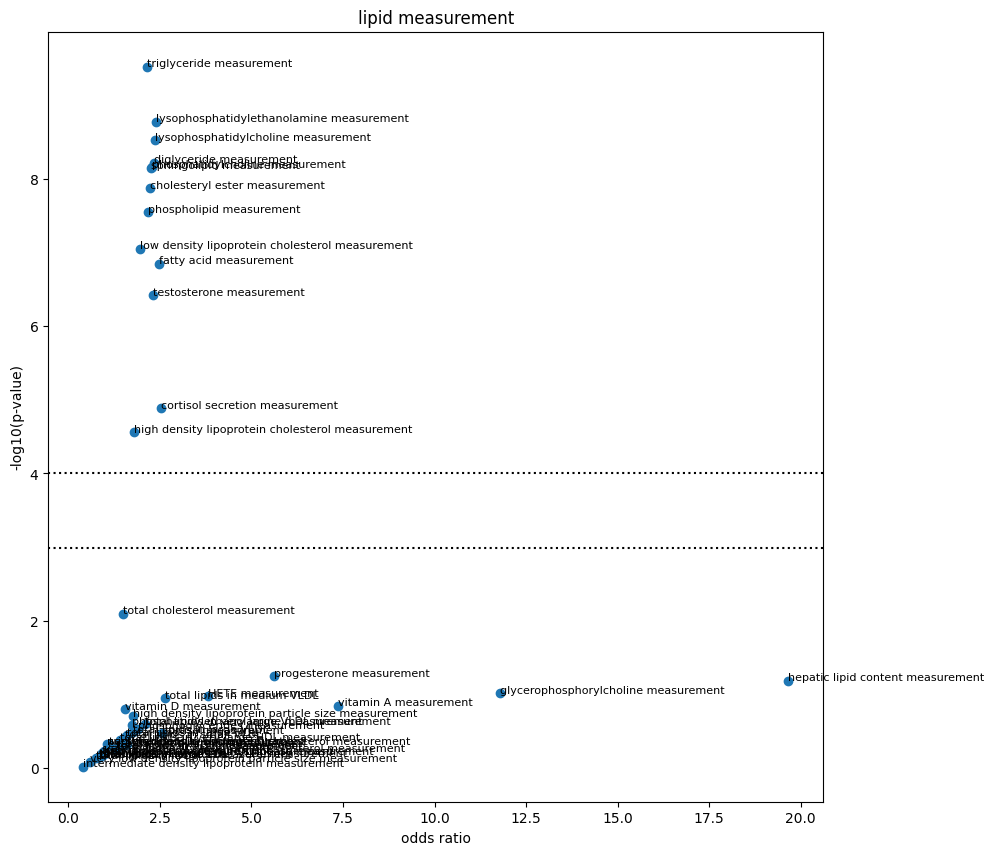

<Figure size 640x480 with 0 Axes>

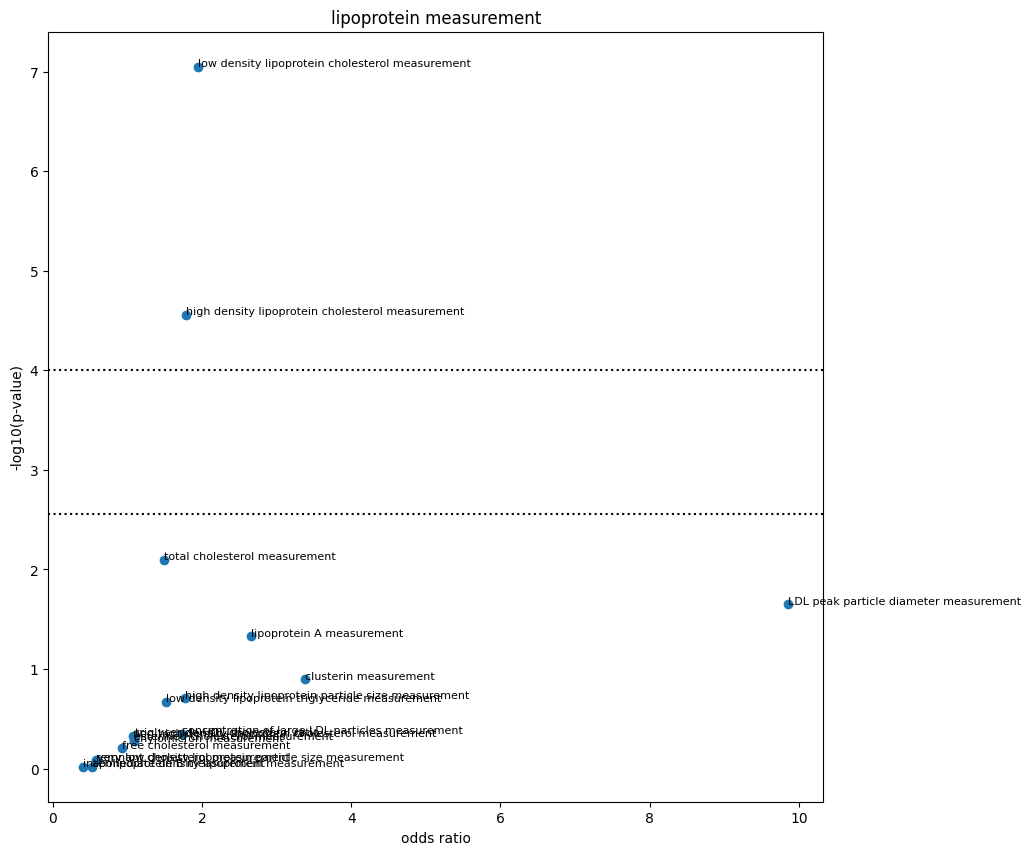

<Figure size 640x480 with 0 Axes>

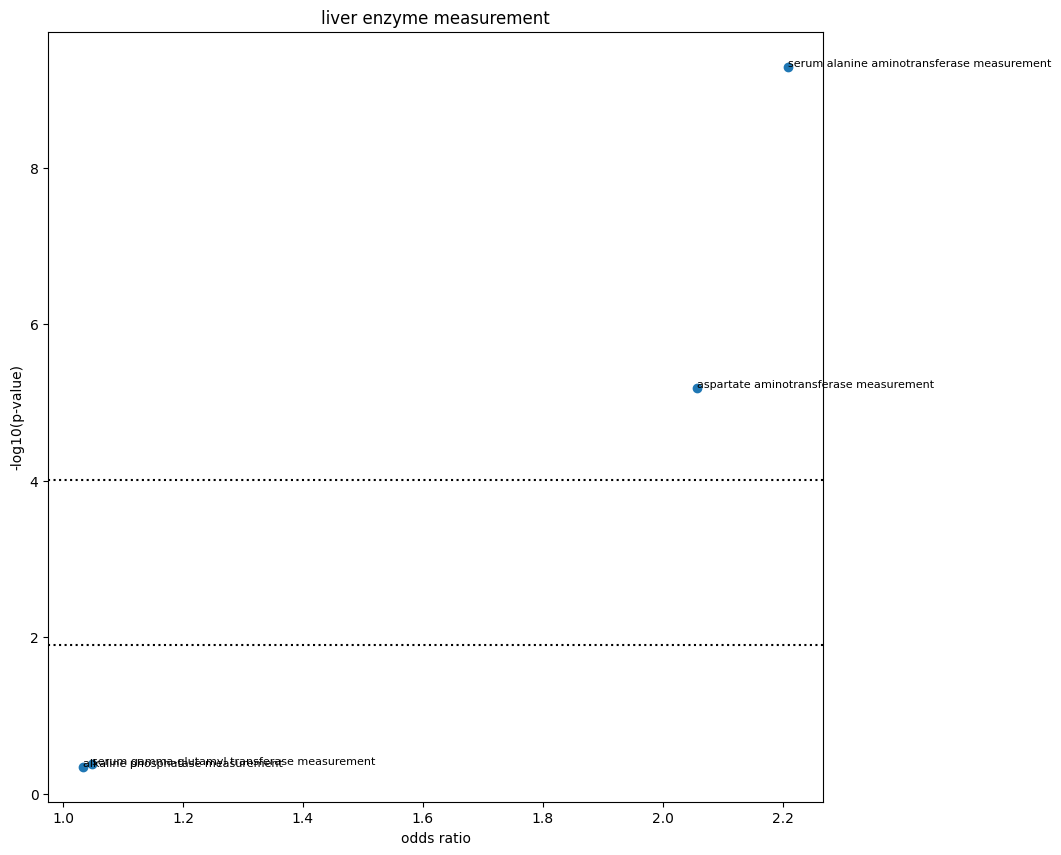

<Figure size 640x480 with 0 Axes>

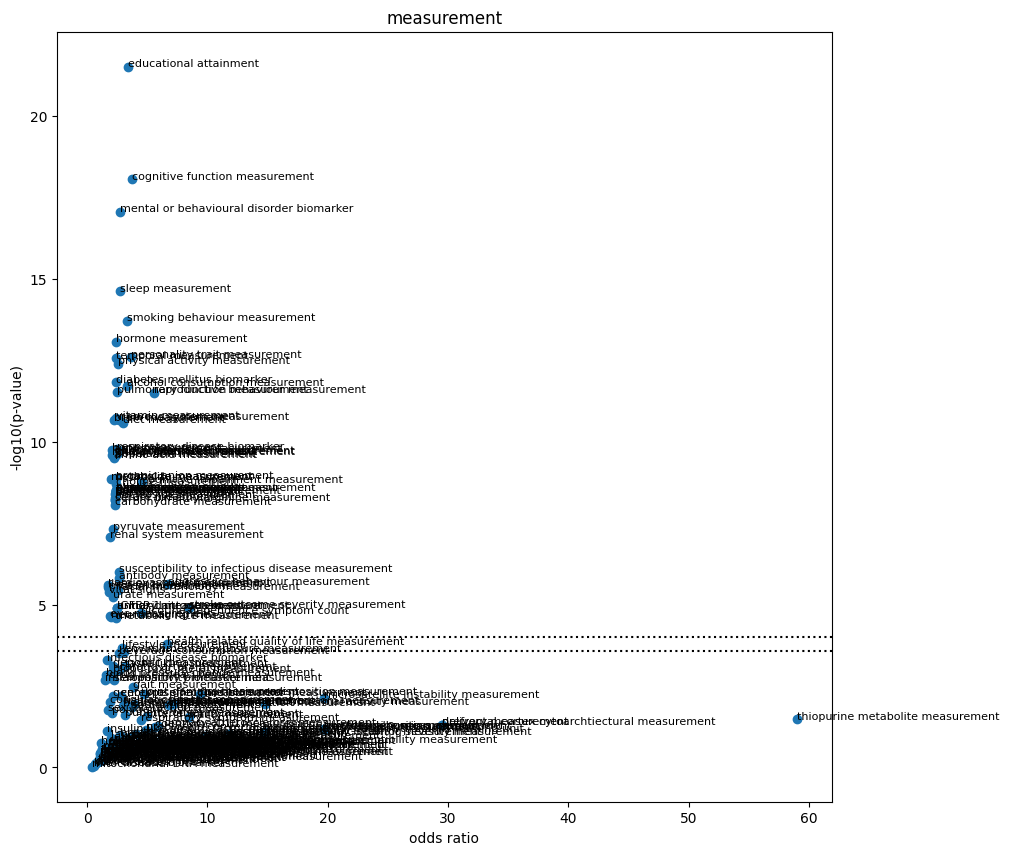

<Figure size 640x480 with 0 Axes>

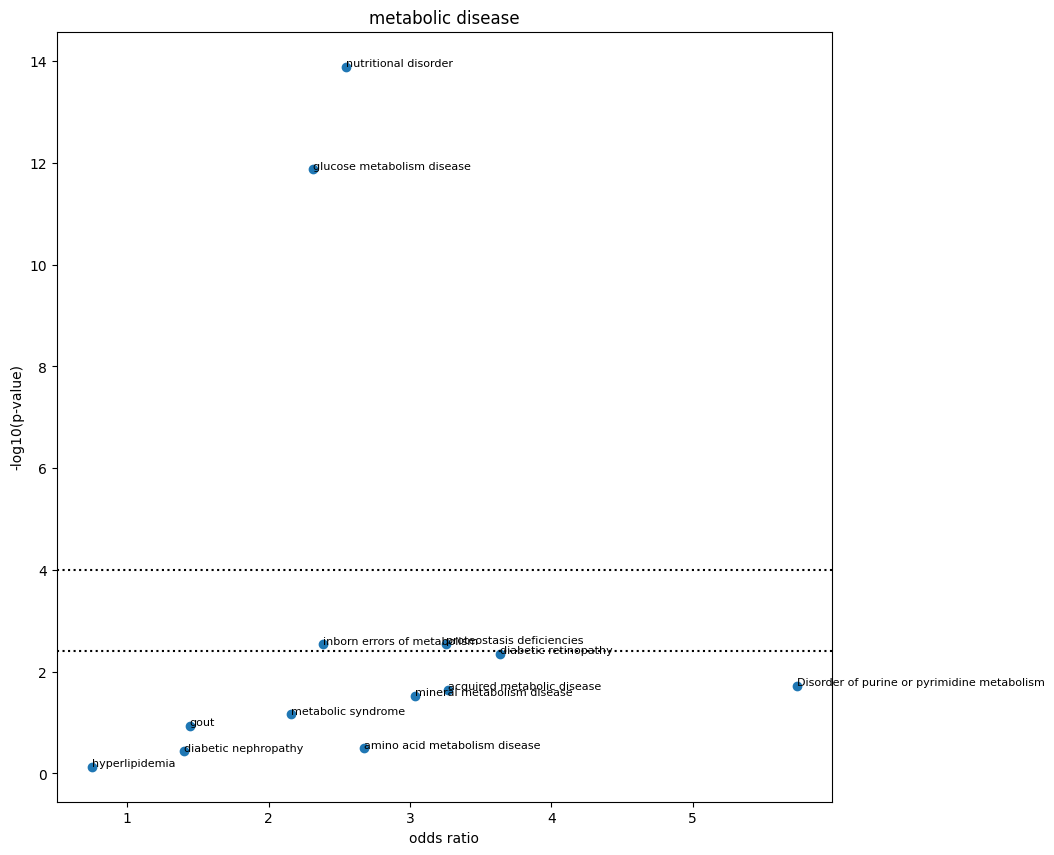

<Figure size 640x480 with 0 Axes>

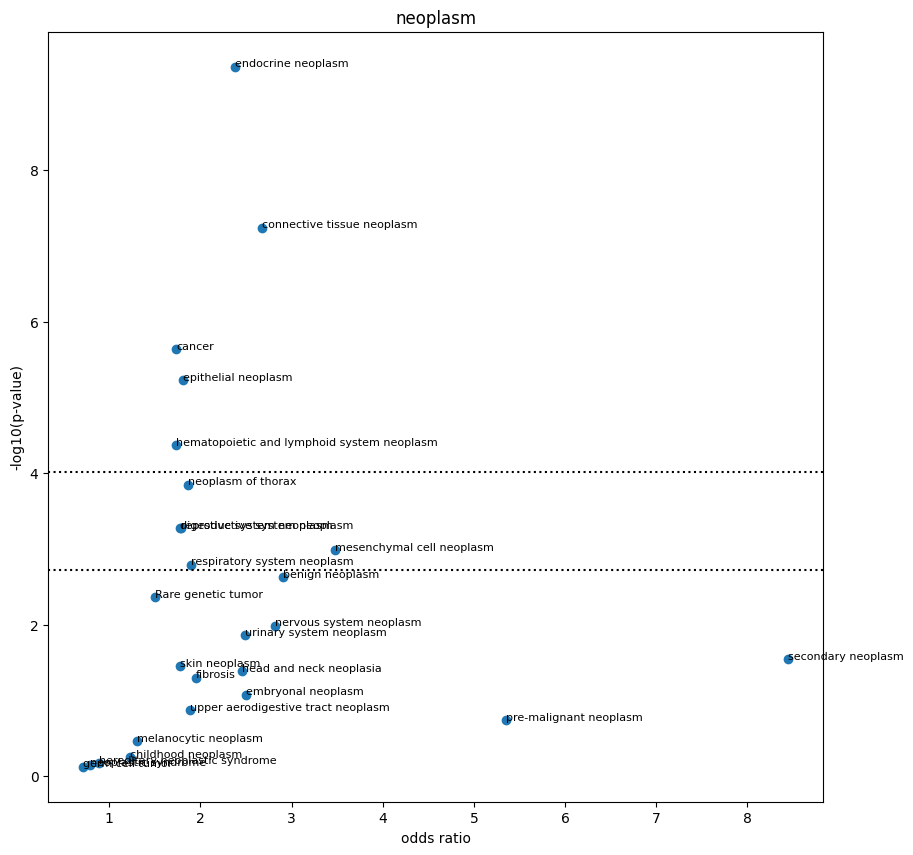

<Figure size 640x480 with 0 Axes>

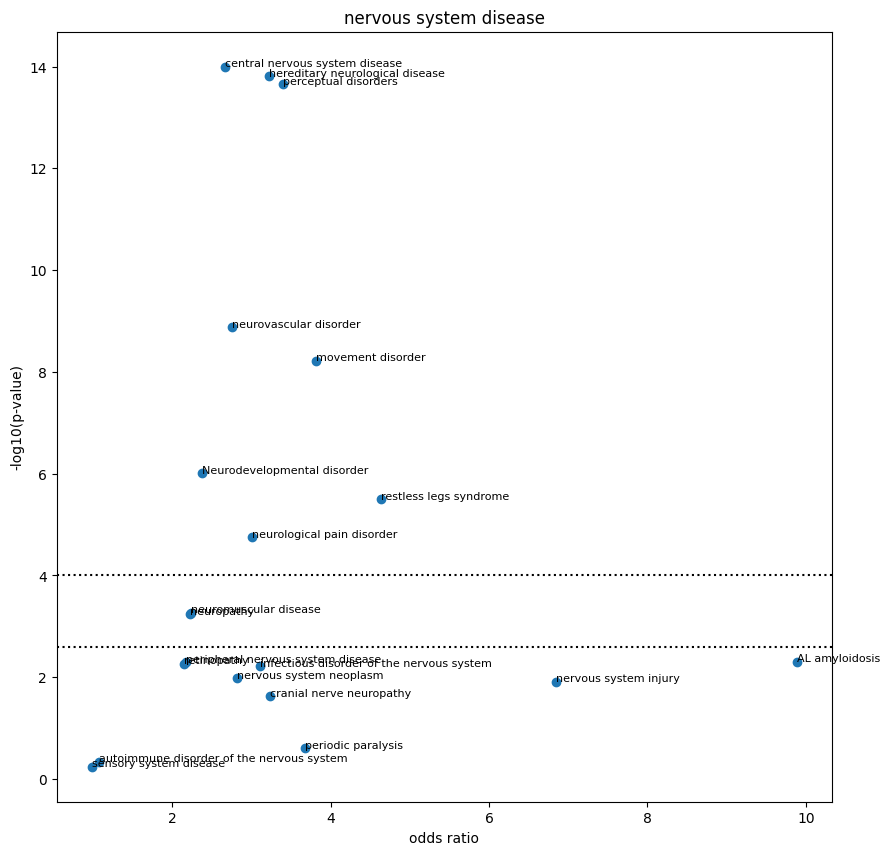

<Figure size 640x480 with 0 Axes>

In [232]:
for p in sorted(set(onto['EFO_parent_idtoname'].dropna())):
    t=enr_tbl[enr_tbl['parent_trait']==p]
    fig=plt.figure(figsize=(10,10))
    fig=plt.scatter(x=t.odds_ratio,y=-np.log10(t.p_intersect))
    fig=plt.xlabel('odds ratio')
    fig=plt.ylabel('-log10(p-value)')
    fig=plt.title(p)
    fig=plt.axhline(-np.log10(0.05/len(enr_tbl)),color='black',ls=':')
    fig=plt.axhline(-np.log10(0.05/len(t)),color='black',ls=':')
    
    for i in t.index:
        plt.annotate(t.trait[i], (t.odds_ratio[i], -np.log10(t.p_intersect[i])), fontsize=8)
    plt.show()
    plt.clf()

In [197]:
sorted(set(onto['EFO_parent_idtoname'].dropna()))

['biological_process',
 'body weights and measures',
 'cardiovascular disease',
 'cardiovascular measurement',
 'digestive system disease',
 'disease',
 'experimental factor',
 'hematological measurement',
 'immune system disease',
 'inflammatory biomarker measurement',
 'lipid measurement',
 'lipoprotein measurement',
 'liver enzyme measurement',
 'measurement',
 'metabolic disease',
 'neoplasm',
 'nervous system disease']

In [194]:
enr_tbl.head()

,trait,parent_trait,network_genes,odds_ratio,p_intersect
0,neurological pain disorder,nervous system disease,"{FOXP1, MAPT, NBEA, CARF, CACNA1H, DPP6, GRM7,...",3.002384,1.761670e-05
1,hereditary neurological disease,nervous system disease,"{FOXP1, KCNN3, MAPT, QSER1, ZNF804A, VEGFA, LU...",3.226210,1.535229e-14
2,neurovascular disorder,nervous system disease,"{FOXP1, KCNN3, MAPT, ZNF804A, ZFPM2, NFIB, LUZ...",2.757542,1.329702e-09
3,perceptual disorders,nervous system disease,"{FOXP1, KCNN3, ZFPM2, TULP4, VEGFA, NFIB, TMEM...",3.393854,2.216010e-14
4,nervous system neoplasm,nervous system disease,"{DGKI, HTR2A, RBFOX1, AKT3, LIN28B, NEGR1, NIC...",2.814411,1.033686e-02


## identify shared parent terms

In [ ]:
parent_term_depth

all parent terms are included under experimental factor

## make upset plot of overlapping network genes between gwas catalog parent terms (with NR)

In [ ]:
gwascat=from_contents(parent_dict_genes)  

In [ ]:
sorted(parent_dict_genes.keys())

In [ ]:
UpSet(gwascat, subset_size='count',show_counts=True).plot()
if save_fig:
    plt.savefig('figures/' + 'gwas_catalog_parent_upset.pdf')

## make upset plot of overlapping genes between gwas catalog parent terms (without NR)

In [ ]:
parent_dict_genes_noNR=parent_dict_genes
parent_dict_genes_noNR.pop('NR')

In [ ]:
gwascat_noNR=from_contents(parent_dict_genes_noNR)

In [ ]:
UpSet(gwascat_noNR, subset_size='count',show_counts=True).plot()
if save_fig:
    plt.savefig('figures/' + 'gwas_catalog_parent_upset_nonr.pdf')

In [ ]:
len(set.intersection(*parent_dict_genes_noNR.values()))

## make upset plot of overlapping traits between gwas catalog parent terms (with NR)

In [ ]:
onto_parent={}
for k in set(onto['Parent term']):
    onto_parent[k]=set(onto[onto['Parent term']==k]['Disease trait'].dropna())
    

In [ ]:
UpSet(from_contents(onto_parent), subset_size='count',show_counts=True).plot()


## choose heirarchy of mutual exclusivity for labels

In [176]:
keys=set(onto_parent.keys())
for i in keys:
    print('\n\t'+i)   
    print('\tn='+str(len(onto_parent[i])))
    for k in keys:
        if i!=k:
            print('overlap of '+i+' with '+k+':')
            print([x for x in onto_parent[i] if (x in onto_parent[k])])

NameError: name 'onto_parent' is not defined

In [ ]:
parent_term_depth

In [ ]:
len_parent={}
for i in keys:
    len_parent[i]=len(onto_parent[i])
len_parent=pd.DataFrame(len_parent.items())
len_parent.merge(),on=0)

In [ ]:
len_parent

In [ ]:
pd.DataFrame(parent_term_depth.items())

In [ ]:
len_parent.merge(pd.DataFrame(parent_term_depth.items()),on=0)


In [ ]:
len_parent.columns=['parent_trait','number_traits']

len_parent=len_parent.sort_values('number_traits')
len_parent.reset_index(inplace=True)
len_parent=len_parent.drop('index',axis=1)

In [ ]:
len_parent['priority']=[17,7,0,8,9,10,1,11,3,4,5,6,16,13,12,14,15]

In [ ]:
len_parent

In [ ]:
len_parent=len_parent.sort_values('priority')
len_parent.reset_index(inplace=True)
len_parent=len_parent.drop('index',axis=1)
len_parent

In [ ]:
len_parent.parent_trait

In [ ]:
for i in (len_parent.parent_trait):
    print('\n\t'+i)   
    print('\tn='+str(len(onto_parent[i])))
    for k in keys:
        if i!=k:
            print([x for x in onto_parent[i] if (x in onto_parent[k])])